# Query Expansion - Improve RAG Retrieval

### Table of Contents

1. **Load Data**
    * Split Data into Chunks
2. **Create Vector Store & Load Text Chunks**
    * Define Vector Store & Collection
    * Add Text Chunks to Collection
    * Visualize Dataset
3. **Query Vector Store (No RAG Trick)**
    * Visualize Original Query & Retrieved Docs
4. **Query Expansion using Generated Answer**
    * Visualize Original Query, Modified Query & Retrieved Docs
5. **Query Expansion using Generated Queries**
    * Visualize Original Query, Generated Queries & Retrieved Docs
6. **RAG Performance**

### Installation

* **pip install groq**
* **pip install langchain**
* **pip install chromadb**

In [1]:
import dotenv
import os

dotenv.load_dotenv(dotenv.find_dotenv())

groq_api_key = os.environ["GROQ_API_KEY"]

In [2]:
import chromadb

print(chromadb.__version__)

0.5.4


* Login to **https://console.groq.com** and create API Key.

<img src="GroqModels.jpg" width=650/>

In [3]:
from groq import Groq

client = Groq(
    api_key=groq_api_key,
)

## 1. Load Data

* **Form 10-K** is a comprehensive report filed annually by a publicly traded company about its financial performance and is required by the **U.S. Securities and Exchange Commission (SEC)**.



In [4]:
from pypdf import PdfReader

reader = PdfReader("Apple-10-k-2023.pdf")

pages = [page.extract_text().strip() for page in reader.pages]
pages = [page for page in pages if page]

len(pages)

80

In [5]:
print(pages[0])

UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
FORM 10-K
(Mark One)
☒    ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the fiscal year ended September 30, 2023
or
☐    TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the transition period from               to              .
Commission File Number: 001-36743
Apple Inc.
(Exact name of Registrant as specified in its charter)
California 94-2404110
(State or other jurisdiction
of incorporation or organization)(I.R.S. Employer Identification No.)
One Apple Park Way
Cupertino , California 95014
(Address of principal executive offices) (Zip Code)
(408) 996-1010
(Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each classTrading 
symbol(s) Name of each exchange on which registered
Common Stock, $0.00001  par value per share AAPL The Nasdaq Stock Market LLC
1.375%

### 1.1 Split Data into Chunks

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

text_splitter  = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=25        
)

character_split_texts = text_splitter.split_text('\n\n'.join(pages))

print(f"Total chunks: {len(character_split_texts)}")

Total chunks: 323


In [7]:
print((character_split_texts[20]))

intellectual property and acquisition of third-party businesses and technology.
Intellectual Property
The Company currently holds a broad collection of intellectual property rights relating to certain aspects of its hardware devices, 
accessories, software and services. This includes patents, designs, copyrights, trademarks and other forms of intellectual 
property rights in the U.S. and various foreign countries. Although the Company believes the ownership of such intellectual 
property rights is an important factor in differentiating its business and that its success does depend in part on such ownership, 
the Company relies primarily on the innovative skills, technical competence and marketing abilities of its personnel.
The Company regularly files patent, design, copyright and trademark applications to protect innovations arising from its research, 
development, design and marketing, and is currently pursuing thousands of applications around the world. Over time, the


## 2. Create Vector Store & Load Text Chunks

### 2.1 Define Vector Store & Collection

* https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models

Check out our **[ChromaDB Tutorial](https://www.youtube.com/watch?v=-ElKVZRNcU8&t=673s)** if you are new to it.

In [8]:
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

chroma_client = chromadb.PersistentClient(path="./apple_10_k")
distilroberta = SentenceTransformerEmbeddingFunction(model_name="all-distilroberta-v1") ## 768 Dimension embeddings vector.

collection = chroma_client.create_collection(name="apple_annual_report_2023", 
                                             metadata={"title": "Apple 10-k Report (2023)", 
                                                       "description": "This store contains embeddings of Apple Annual Report filed to SEC for 2023."},
                                             embedding_function=distilroberta,
                                             get_or_create=True)

### 2.2 Add Text Chunks to Vector Store

* Do not rerun this step if you have already ran it earlier. It'll add same texts again in persisted collection.

In [16]:
collection.add(
    documents=character_split_texts,
    ids=[f"Split-{idx}" for idx in range(len(character_split_texts))]
)

323

In [9]:
collection.count()

323

### 2.3 Visualize Text Chunks

In [10]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = collection.get(include=['embeddings'])['embeddings']
umap_projector = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_projector):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_projector.transform([embedding])
    return umap_embeddings   

projected_dataset_embeddings = project_embeddings(embeddings, umap_projector)

2024-08-15 01:49:49.207593: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 01:49:49.239726: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 01:49:49.994755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|█████████████████████████████████████████████████████████████████████████████████| 323/323 [02:40<00:00,  2.01it/s]


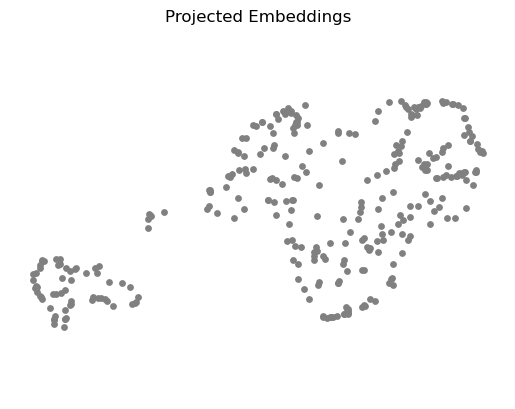

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="grey")
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off');

## 3. Query Vector Store

In [12]:
#query = "What was the total revenue?"
query = "What are risk factors for the company?"

results = collection.query(query_texts=[query], n_results=5, include=['documents', 'embeddings'])

results.keys()

dict_keys(['ids', 'distances', 'metadatas', 'embeddings', 'documents', 'uris', 'data', 'included'])

In [13]:
retrieved_documents1 = results['documents'][0]

for document in retrieved_documents1:
    print(document)
    print('==========================================')

Item 1A. Risk Factors
The Company’s business, reputation, results of operations, financial condition and stock price can be affected by a number of 
factors, whether currently known or unknown, including those described below. When any one or more of these risks materialize 
from time to time, the Company’s business, reputation, results of operations, financial condition and stock price can be materially 
and adversely affected.
Because of the following factors, as well as other factors affecting the Company’s results of operations and financial condition, 
past financial performance should not be considered to be a reliable indicator of future performance, and investors should not 
use historical trends to anticipate results or trends in future periods. This discussion of risk factors contains forward-looking 
statements.
This section should be read in conjunction with Part II, Item 7, “Management’s Discussion and Analysis of Financial Condition
instability; inability to obtain credit

### Visualize Dataset, Query & Retrieved Docs

In [14]:
retrieved_docs_embeddings = results['embeddings'][0]
original_query_embeddings = distilroberta([query])

projected_original_query_embedding = project_embeddings(original_query_embeddings, umap_projector)
projected_retrieved_embeddings = project_embeddings(retrieved_docs_embeddings, umap_projector)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


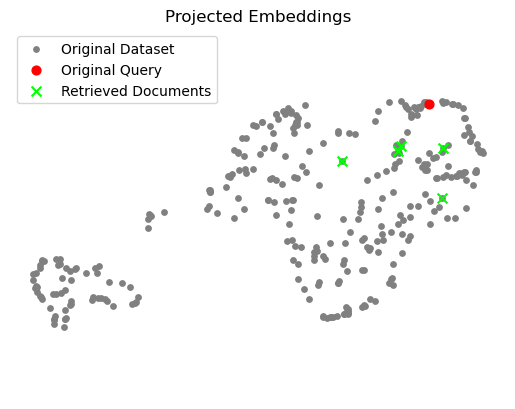

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="grey", label="Original Dataset")
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=40, c="red", label="Original Query")
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=50, marker="x", c="lime", label="Retrieved Documents")
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.legend(loc="best");
plt.axis('off');

## 4. Query Expansion with Generated Answer

* **Reference Paper** - https://arxiv.org/abs/2305.03653


In [21]:
def generate_answer(query, model="llama-3.1-70b-versatile"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

generated_answer = generate_answer(query)

print(generated_answer)

**RISK FACTORS**

Our business is subject to a number of risks and uncertainties that could affect our financial condition and results of operations. The following is a summary of some of the key risk factors that may impact our business:

1. **Economic and Market Risks**: Our business is heavily influenced by global and regional economic conditions, including recession, inflation, interest rates, and market volatility. A decline in economic conditions could reduce demand for our products and services, while increased inflation or interest rates could reduce our profitability.
2. **Competition and Market Share**: Our industry is highly competitive, and we face significant competition from established players and new entrants. If we are unable to maintain or increase our market share, our revenue and profitability could be negatively impacted.
3. **Regulatory and Compliance Risks**: Our business is subject to various laws, regulations, and standards, including those related to data prot

In [22]:
joint_query = f"{query}\n\n{generated_answer}"

print(joint_query)

What are risk factors for the company?

**RISK FACTORS**

Our business is subject to a number of risks and uncertainties that could affect our financial condition and results of operations. The following is a summary of some of the key risk factors that may impact our business:

1. **Economic and Market Risks**: Our business is heavily influenced by global and regional economic conditions, including recession, inflation, interest rates, and market volatility. A decline in economic conditions could reduce demand for our products and services, while increased inflation or interest rates could reduce our profitability.
2. **Competition and Market Share**: Our industry is highly competitive, and we face significant competition from established players and new entrants. If we are unable to maintain or increase our market share, our revenue and profitability could be negatively impacted.
3. **Regulatory and Compliance Risks**: Our business is subject to various laws, regulations, and standar

In [23]:
results = collection.query(query_texts=[joint_query], n_results=5, include=['documents', 'embeddings'])

retrieved_documents2 = results['documents'][0]

for document in retrieved_documents2:
    print(document)
    print('==========================================')

The Company is subject to complex and changing laws and regulations worldwide, which exposes the Company to 
potential liabilities, increased costs and other adverse effects on the Company’s business.
The Company’s global operations are subject to complex and changing laws and regulations on subjects, including antitrust; 
privacy, data security and data localization; consumer protection; advertising, sales, billing and e-commerce; financial services 
and technology; product liability; intellectual property ownership and infringement; digital platforms; machine learning and 
artificial intelligence; internet, telecommunications and mobile communications; media, television, film and digital content; 
availability of third-party software applications and services; labor and employment; anticorruption; import, export and trade; 
foreign exchange controls and cash repatriation restrictions; anti–money laundering; foreign ownership and investment; tax; and
construction and operation; manage

### Visualize Dataset, Query & Retrieved Docs

In [24]:
retrieved_docs_embeddings = results['embeddings'][0]
original_query_embeddings = distilroberta([query])
joint_query_embeddings = distilroberta([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embeddings, umap_projector)
projected_joint_query_embedding = project_embeddings(joint_query_embeddings, umap_projector)
projected_retrieved_embeddings = project_embeddings(retrieved_docs_embeddings, umap_projector)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


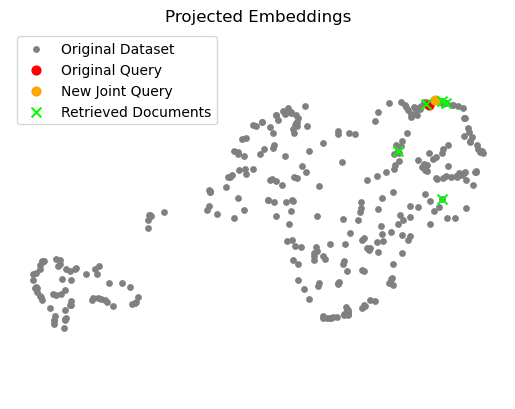

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="grey", label="Original Dataset")
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=40, c="red", label="Original Query")
plt.scatter(projected_joint_query_embedding[:, 0], projected_joint_query_embedding[:, 1], s=40, c="orange", label="New Joint Query")
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=50, marker="x", c="lime", label="Retrieved Documents")
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.legend(loc="best");
plt.axis('off');

## 5. Query Expansion using Generated Queries

In [31]:
def generate_queries(query, model="llama-3.1-70b-versatile"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [32]:
augmented_queries = generate_queries(query)
augmented_queries = [query for query in augmented_queries if query.strip()]

for query in augmented_queries:
    print(query)

What are the company's most significant risk factors?
How does the company manage cybersecurity threats?
Are there any pending lawsuits or regulatory issues?
What is the company's disaster recovery plan?
How does the company assess and prioritize potential risks?


In [33]:
queries = [query] + augmented_queries
results = collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)
        
len(queries), len(unique_documents)

(6, 19)

### Visualize Dataset, Query & Retrieved Docs Embeddings

In [34]:
retrieved_docs_embeddings = results['embeddings']
retrieved_docs_embeddings = [item for sublist in retrieved_docs_embeddings for item in sublist]
original_query_embeddings = distilroberta([query])
queries_embeddings = distilroberta(queries)

projected_original_query_embedding = project_embeddings(original_query_embeddings, umap_projector)
projected_queries_embedding = project_embeddings(queries_embeddings, umap_projector)
projected_retrieved_embeddings = project_embeddings(retrieved_docs_embeddings, umap_projector)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.13it/s]


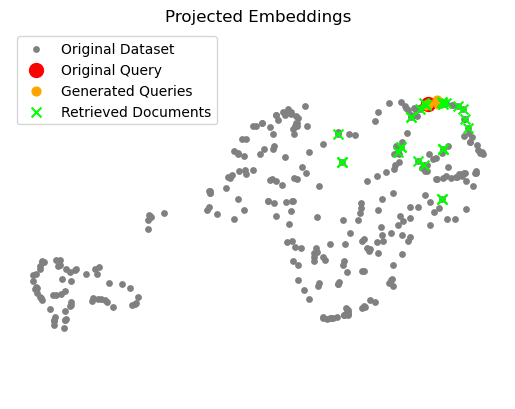

In [35]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="grey", label="Original Dataset")
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=100, c="red", label="Original Query")
plt.scatter(projected_queries_embedding[:, 0], projected_queries_embedding[:, 1], s=40, c="orange", label="Generated Queries")
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=50, marker="x", c="lime", label="Retrieved Documents")
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.legend(loc="best");
plt.axis('off');

## 6. Build RAG

In [42]:
def rag(query, retrieved_documents, model="llama-3.1-70b-versatile"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": "You are an expert financial research assistant. Your users are asking questions about information contained in an annual report."
            "You will be given the user's query, and the relevant information from the annual report. Answer the user's question using only this information."
        },
        {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
    ]
    
    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [46]:
output = rag(query=query, retrieved_documents=retrieved_documents1)

print(output)

Unfortunately, the provided information does not specifically mention how the company assesses and prioritizes potential risks. It outlines the various types of risks the company is exposed to, such as adverse economic conditions, business interruptions, quality problems, supply chain risks, cybersecurity attacks, climate change, and the like, as well as factors that may affect its results of operations, financial condition, and stock price.

However, it does mention that this discussion of risk factors should be read in conjunction with Part II, Item 7, "Management's Discussion and Analysis of Financial Condition", which might indicate that further risk assessment information may be found in that section, although this is only speculation without access to the content of that part.

As this response doesn't cover information requested within those materials mentioned this material section simply represents parts one wouldn't investigate via actual Q orA requests through so hopefully a

In [47]:
output = rag(query=query, retrieved_documents=retrieved_documents2)

print(output)

According to the provided information, the company assesses and prioritizes potential risks through identifying and categorizing various types of risks that could impact its business, results of operations, and financial condition. These risks include:

1. Legal and Regulatory Compliance Risks: Compliance with complex and changing laws and regulations worldwide, potential liabilities, increased costs, and other adverse effects.
2. Business Risks: Managing frequent introductions and transitions of products and services, stimulating customer demand, and successfully managing the transition to new and upgraded products and services.
3. Economic Risks: Adverse economic conditions, instability, inability to obtain credit, insolvency, increased credit and collectibility risk, limitations on issuing new debt, reduced liquidity, and declines in the fair values of financial instruments.
4. Operational Risks: Political events, trade and other international disputes, war, terrorism, natural disas

In [49]:
output = rag(query=query, retrieved_documents=unique_documents)

print(output)

The company assesses and prioritizes potential risks through a comprehensive risk management process. The company identifies potential risks in various areas, including:

1. Legal and Regulatory Compliance Risks: The company is subject to various laws and regulations worldwide, which exposes it to potential liabilities, increased costs, and other adverse effects on its business.
2. Business Risks: The company faces risks related to its business operations, including the introduction of new products and services, managing relationships with existing retail partners, and obtaining and renewing leases in quality retail locations.
3. Information Technology Risks: The company's business and reputation are impacted by information technology system failures and network disruptions.
4. Intellectual Property Risks: The company faces risks related to patent claims and infringement actions.
5. Environmental, Social, and Governance Risks: The company is exposed to potential liabilities, increased 

## Summary

In this video, I explained how to improve RAG app performance using **Query Expansion** technique. Please feel free to let me know your views.